**Проблема: адаптация больших моделей.**

Модели обучаются на общих наборах данных для решения широкого спектра задач и могут плохо подходить для решения конкретных задач (down-stream task), поэтому возникает необходимость дообучать модели (fine-tuning).

Существующие подходы:

1) Полный или частичный fine-tuning исходной модели: часть слоёв модели (или все) обучается заново под конкретную задачу, то есть от исходной модели остаётся только архитектура, инициализация весов и замороженные слои.
- требует значительных вычислительных ресурсов на обучение
- для каждой задачи нужно хранить отдельную модель (в случае LLM это могут быть сотни ГБ)
- может привести к катастрофическому забыванию (модель "забывает" свои исходные знания)

2) Adapter Layers: добавление в модель специальных слоёв, которые обучаются, в то время, как остальная модель заморожена
- за счёт последовательной структуры плохо ускоряется с помощью параллельных вычислений, что значительно замедляет их работу

3) BitFit: обучение только bias векторов, а остальные параметры заморожены
- низкая точность
- малое число параметров

LoRA (Low-Rank adaptation)

Базовая гипотеза (эмпирическая): обновление весов при fine-tuning имеет низкий внутренний ранг, то есть модель подстраивается под задачу, изменяя веса в очень ограниченном подпространстве весов.

Реализация:
1. Исходная матрица весов предобученной модели W фиксируется.
2. Добавляем обучаемое изменение весов ΔW, которое задаётся двумя матрицами A и B (A и B имеют маленький ранг r, который является гиперпараметром LoRA адаптера)
3. Итоговая матрица весов считается как W' = W + ΔW, ΔW = B*A

*При увеличении r этот подход сходится к полному fine-tuning

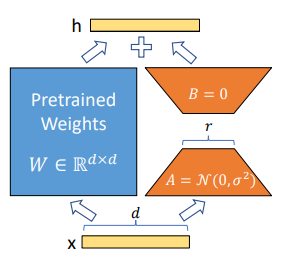

Преимущества LoRA:
- Использование небольшого числа параметров для обучения (~1% от общего числа), что уменьшает время обучения (на 20-25% по сравнению с full fine-tuning) и объём VRAM (на 30-50% по сравнению с full fine-tuning)
- Точность сравнимая с полным переобучением или даже превосходящая его
- Из-за линейности изменения матрицы весов нет необходимости сохранять всю модель для конкретной задачи. Можно сохранить лишь матрицы A и B, что занимает значительно меньше памяти и позволяет быстро переключаться между задачами
- Очень гибкий подход, который может объединяться с другими методами fine-tuning


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == 

In [ ]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from datasets import load_dataset
from peft import get_peft_model, LoraConfig, TaskType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# подсчёт относительного количества обучаемых параметров
def count_trainable_parameters(model, label):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"{label}: {trainable} / {total} ({100 * trainable / total:.4f}%) trainable parameters")

In [ ]:
# функция для обучения
def train(model, label, train_loader, eval_loader, epochs=3, lr=3e-4):
    model.to(device)
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)


    lr_scheduler = get_linear_schedule_with_warmup(
      optimizer=optimizer,
      num_warmup_steps=0.06 * (len(train_loader) * epochs),
      num_training_steps=(len(train_loader) * epochs),
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch) # forward pass
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_loader):.4f}")

        model.eval()
        correct = 0
        total = 0
        for batch in eval_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            preds = outputs.logits.argmax(dim=-1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
        acc = correct / total
        print(f"Epoch {epoch + 1}: validation accuracy = {acc:.4f}")

In [ ]:
# функция для оценки модели
def evaluate(model, eval_loader):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in eval_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = outputs.logits.argmax(dim=-1)
            correct += (preds == batch["labels"]).sum().item()
            total += batch["labels"].size(0)
    acc = correct / total
    return acc

In [ ]:
def base_model(model_name, train_loader, eval_loader, epochs=3, lr=3e-4):
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()
  start_mem = torch.cuda.memory_allocated() / 1024**2
  start_time = time.time()

  # размораживаем только "решающую голову"
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
  for param in model.parameters():
      param.requires_grad = False
  for param in model.classifier.parameters():
      param.requires_grad = True
  count_trainable_parameters(model, "Base Model")
  train(model, "Base Model", train_loader=train_loader, eval_loader=eval_loader, epochs=epochs, lr=lr)
  acc = evaluate(model, eval_loader=eval_loader)

  end_time = time.time()
  end_mem = torch.cuda.memory_allocated() / 1024**2
  peak_mem = torch.cuda.max_memory_allocated() / 1024**2
  print(f"Validation Accuracy: {acc:.4f}")
  print(f"Time: {end_time - start_time:.2f} s")
  print(f"VRAM start: {start_mem:.2f} MB")
  print(f"VRAM end: {end_mem:.2f} MB")
  print(f"VRAM peak: {peak_mem:.2f} MB")
  print(f"VRAM usage: {peak_mem - start_mem:.2f} MB")
  return acc, end_time - start_time, peak_mem - start_mem

In [ ]:
def lora_adapter(model_name, train_loader, eval_loader, target_modules, epochs=3, lr=3e-4, r=8, lora_alpha=16, lora_dropout=0.1):
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()
  start_mem = torch.cuda.memory_allocated() / 1024**2
  start_time = time.time()

  base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
  config = LoraConfig(task_type=TaskType.SEQ_CLS, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout, target_modules=target_modules, inference_mode=False)
  model = get_peft_model(base_model, config)
  count_trainable_parameters(model, "LoRA Fine-Tune")
  train(model, label="LoRA Fine-Tune", train_loader=train_loader, eval_loader=eval_loader, epochs=epochs, lr=lr)
  acc = evaluate(model, eval_loader=eval_loader)

  end_time = time.time()
  end_mem = torch.cuda.memory_allocated() / 1024**2
  peak_mem = torch.cuda.max_memory_allocated() / 1024**2
  print(f"Validation Accuracy: {acc:.4f}")
  print(f"Time: {end_time - start_time:.2f} s")
  print(f"VRAM start: {start_mem:.2f} MB")
  print(f"VRAM end: {end_mem:.2f} MB")
  print(f"VRAM peak: {peak_mem:.2f} MB")
  print(f"VRAM usage: {peak_mem - start_mem:.2f} MB")
  return acc, end_time - start_time, peak_mem - start_mem

In [ ]:
def FFT_model(model_name, train_loader, eval_loader, epochs=3, lr=3e-4):
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()
  start_mem = torch.cuda.memory_allocated() / 1024**2
  start_time = time.time()

  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
  count_trainable_parameters(model, "Full Fine-Tune")
  train(model, "Full Fine-Tune", train_loader=train_loader, eval_loader=eval_loader, epochs=epochs, lr=lr)
  acc = evaluate(model, eval_loader=eval_loader)

  end_time = time.time()
  end_mem = torch.cuda.memory_allocated() / 1024**2
  peak_mem = torch.cuda.max_memory_allocated() / 1024**2
  print(f"Validation Accuracy: {acc:.4f}")
  print(f"Time: {end_time - start_time:.2f} s")
  print(f"VRAM start: {start_mem:.2f} MB")
  print(f"VRAM end: {end_mem:.2f} MB")
  print(f"VRAM peak: {peak_mem:.2f} MB")
  print(f"VRAM usage: {peak_mem - start_mem:.2f} MB")
  return acc, end_time - start_time, peak_mem - start_mem

In [ ]:
def vizualize_time(acc_sst2, time_sst2):
  data = {
    'Model': ['Destil-Berta', 'Destil-Berta', 'Destil-Berta', 'ELECTRA', 'ELECTRA', 'ELECTRA'],
    'Scenario': ['Base', 'LoRA', 'FFT'] * 2,
    'Time (s)': time_sst2,
    'Accuracy': acc_sst2
  }
  df = pd.DataFrame(data)

  fig, ax1 = plt.subplots(figsize=(8, 6))
  sns.barplot(x='Scenario', y='Time (s)', hue='Model', data=df, palette='coolwarm', alpha=0.6, ax=ax1)
  ax1.set_ylabel('Time (s)', color='tab:blue')
  ax1.tick_params(axis='y', labelcolor='tab:blue')

  ax2 = ax1.twinx()
  sns.lineplot(x='Scenario', y='Accuracy', hue='Model', data=df, palette='dark', marker='o', dashes=False, ax=ax2)
  ax2.set_ylabel('Accuracy score', color='tab:red')
  ax2.tick_params(axis='y', labelcolor='tab:red')

  handles1, labels1 = ax1.get_legend_handles_labels()
  handles2, labels2 = ax2.get_legend_handles_labels()
  ax1.get_legend().remove()
  ax2.get_legend().remove()
  all_handles = handles1 + handles2
  all_labels = labels1 + labels2
  fig.legend(handles=all_handles, labels=all_labels, title='Model', bbox_to_anchor = (0.15, 0.85), loc='upper left')

  plt.title('Performance on SST2')
  plt.show()

In [ ]:
def vizualize_vram(acc_sst2, vram_sst2):
  data = {
    'Model': ['Destil-Berta', 'Destil-Berta', 'Destil-Berta', 'ELECTRA', 'ELECTRA', 'ELECTRA'],
    'Scenario': ['Base', 'LoRA', 'FFT'] * 2,
    'Memory (MB)': vram_sst2,
    'Accuracy': acc_sst2
  }
  df = pd.DataFrame(data)

  fig, ax1 = plt.subplots(figsize=(8, 6))
  sns.barplot(x='Scenario', y='Memory (MB)', hue='Model', data=df, palette='coolwarm', alpha=0.6, ax=ax1)
  ax1.set_ylabel('VRAM (MB)', color='tab:blue')
  ax1.tick_params(axis='y', labelcolor='tab:blue')

  ax2 = ax1.twinx()
  sns.lineplot(x='Scenario', y='Accuracy', hue='Model', data=df, palette='dark', marker='o', dashes=False, ax=ax2)
  ax2.set_ylabel('Accuracy score', color='tab:red')
  ax2.tick_params(axis='y', labelcolor='tab:red')

  handles1, labels1 = ax1.get_legend_handles_labels()
  handles2, labels2 = ax2.get_legend_handles_labels()
  ax1.get_legend().remove()
  ax2.get_legend().remove()
  all_handles = handles1 + handles2
  all_labels = labels1 + labels2
  fig.legend(handles=all_handles, labels=all_labels, title='Model', bbox_to_anchor = (0.15, 0.85), loc='upper left')

  plt.title('Performance on SST2')
  plt.show()

**Бинарная классификация (датасет sst2)**

In [ ]:
# Загружаем датасет SST-2
def load_sst2(model_name, data_len=3000, batch_size=16):
  dataset = load_dataset("glue", "sst2")

  tokenizer = AutoTokenizer.from_pretrained(model_name) # предобученный токенизатор

  # разбивает текст на токены и приводит к одной длине
  def tokenize(example):
      return tokenizer(example["sentence"], padding="max_length", truncation=True, max_length=128)

  dataset_mapped = dataset.map(tokenize, batched=True) # применяем токенизатор ко всему датасету по батчам
  dataset_mapped = dataset_mapped.rename_column("label", "labels")
  dataset_mapped.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

  train_loader = DataLoader(dataset_mapped["train"].shuffle(seed=42).select(range(data_len)), batch_size=batch_size)
  eval_loader = DataLoader(dataset_mapped["validation"], batch_size=batch_size)
  return train_loader, eval_loader

In [ ]:
acc_sst2 = np.zeros(6)
time_sst2 = np.zeros(6)
vram_sst2 = np.zeros(6)

DestilBerta base (~7M)

In [ ]:
model_name = "distilbert-base-uncased"
train_loader , eval_loader = load_sst2(model_name)

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Базовая модель с дообучением только последнего слоя классификатора

In [ ]:
acc, wall_time, vram = base_model(model_name, train_loader, eval_loader, epochs=3, lr=3e-3)
acc_sst2[0] = acc
time_sst2[0] = wall_time
vram_sst2[0] = vram

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base Model: 1538 / 66955010 (0.0023%) trainable parameters
Epoch 1: Loss = 0.6408
Epoch 1: validation accuracy = 0.6101
Epoch 2: Loss = 0.5835
Epoch 2: validation accuracy = 0.6972
Epoch 3: Loss = 0.5577
Epoch 3: validation accuracy = 0.7993
Validation Accuracy: 0.7993
Time: 40.17 s
VRAM start: 280.71 MB
VRAM end: 537.96 MB
VRAM peak: 629.01 MB
VRAM usage: 348.29 MB


LoRA Adapter

In [ ]:
acc, wall_time, vram = lora_adapter(model_name, train_loader, eval_loader, ['q_lin', 'v_lin'], epochs=3, lr=5e-4, r=8, lora_alpha=16, lora_dropout=0.1)
acc_sst2[1] = acc
time_sst2[1] = wall_time
vram_sst2[1] = vram

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA Fine-Tune: 739586 / 67694596 (1.0925%) trainable parameters
Epoch 1: Loss = 0.4166
Epoch 1: validation accuracy = 0.8452
Epoch 2: Loss = 0.2757
Epoch 2: validation accuracy = 0.8624
Epoch 3: Loss = 0.2177
Epoch 3: validation accuracy = 0.8635
Validation Accuracy: 0.8635
Time: 72.35 s
VRAM start: 280.71 MB
VRAM end: 540.78 MB
VRAM peak: 1061.20 MB
VRAM usage: 780.49 MB


Полный fine-tuning модели

In [ ]:
acc, wall_time, vram = FFT_model(model_name, train_loader, eval_loader, epochs=3, lr=5e-5)
acc_sst2[2] = acc
time_sst2[2] = wall_time
vram_sst2[2] = vram

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full Fine-Tune: 66955010 / 66955010 (100.0000%) trainable parameters
Epoch 1: Loss = 0.4104
Epoch 1: validation accuracy = 0.8383
Epoch 2: Loss = 0.1580
Epoch 2: validation accuracy = 0.8727
Epoch 3: Loss = 0.0498
Epoch 3: validation accuracy = 0.8601
Validation Accuracy: 0.8601
Time: 104.60 s
VRAM start: 280.71 MB
VRAM end: 537.96 MB
VRAM peak: 1700.50 MB
VRAM usage: 1419.79 MB


ELECTRA (~110M)

In [ ]:
model_name = "google/electra-base-discriminator"
train_loader , eval_loader = load_sst2(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

Базовая модель с дообучением только последнего слоя классификатора

In [ ]:
acc, wall_time, vram = base_model(model_name, train_loader, eval_loader, epochs=3, lr=3e-4)
acc_sst2[3] = acc
time_sst2[3] = wall_time
vram_sst2[3] = vram

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base Model: 592130 / 109483778 (0.5408%) trainable parameters


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Loss = 0.6648
Epoch 1: validation accuracy = 0.6261
Epoch 2: Loss = 0.6265
Epoch 2: validation accuracy = 0.6628
Epoch 3: Loss = 0.6123
Epoch 3: validation accuracy = 0.7317
Validation Accuracy: 0.7317
Time: 89.14 s
VRAM start: 280.71 MB
VRAM end: 700.20 MB
VRAM peak: 790.24 MB
VRAM usage: 509.53 MB


LoRa Adapter

In [ ]:
acc, wall_time, vram = lora_adapter(model_name, train_loader, eval_loader, ['query', 'value', 'dense'], epochs=3, lr=5e-4, r=8, lora_alpha=16, lora_dropout=0.1)
acc_sst2[4] = acc
time_sst2[4] = wall_time
vram_sst2[4] = vram

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA Fine-Tune: 1784066 / 111280132 (1.6032%) trainable parameters
Epoch 1: Loss = 0.3871
Epoch 1: validation accuracy = 0.9266
Epoch 2: Loss = 0.1851
Epoch 2: validation accuracy = 0.9323
Epoch 3: Loss = 0.1212
Epoch 3: validation accuracy = 0.9312
Validation Accuracy: 0.9312
Time: 178.72 s
VRAM start: 280.71 MB
VRAM end: 707.05 MB
VRAM peak: 2525.83 MB
VRAM usage: 2245.12 MB


Полный fine-tuning модели

In [ ]:
acc, wall_time, vram = FFT_model(model_name, train_loader, eval_loader, epochs=3, lr=5e-5)
acc_sst2[5] = acc
time_sst2[5] = wall_time
vram_sst2[5] = vram

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full Fine-Tune: 109483778 / 109483778 (100.0000%) trainable parameters
Epoch 1: Loss = 0.4997
Epoch 1: validation accuracy = 0.9060
Epoch 2: Loss = 0.2126
Epoch 2: validation accuracy = 0.9220
Epoch 3: Loss = 0.0929
Epoch 3: validation accuracy = 0.9323
Validation Accuracy: 0.9323
Time: 208.50 s
VRAM start: 280.71 MB
VRAM end: 700.20 MB
VRAM peak: 3123.58 MB
VRAM usage: 2842.87 MB


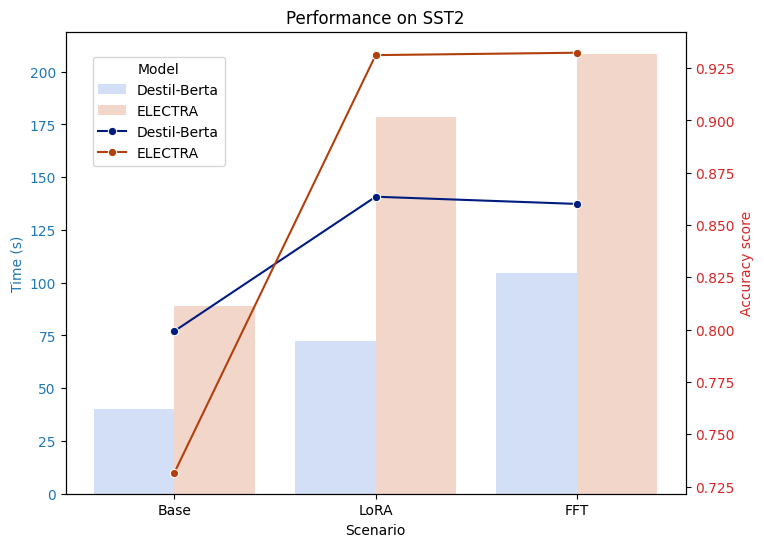

In [ ]:
vizualize_time(acc_sst2, time_sst2)

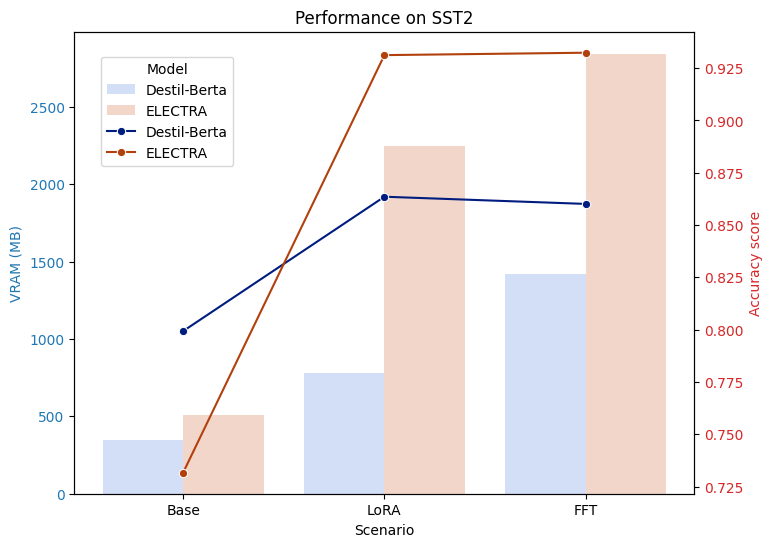

In [ ]:
vizualize_vram(acc_sst2, vram_sst2)

**Семантический тест (mrpc)**

In [ ]:
# Загружаем датасет MRPC
def load_mrpc(model_name, data_len=3000, batch_size=16):
  dataset = load_dataset("glue", "mrpc")
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  def tokenize(example):
      return tokenizer(example["sentence1"], example["sentence2"], truncation=True, max_length=None)

  dataset_mapped = dataset.map(tokenize, batched=True, remove_columns=["idx", "sentence1", "sentence2"])
  dataset_mapped = dataset_mapped.rename_column("label", "labels")

  # переводит в тензоры и приводит к одной длине
  def collate_fn(example):
      return tokenizer.pad(example, padding="longest", return_tensors="pt")

  train_loader = DataLoader(dataset_mapped["train"].shuffle(seed=42).select(range(3000)), collate_fn=collate_fn, batch_size=16)
  eval_loader = DataLoader(dataset_mapped["validation"], collate_fn=collate_fn, batch_size=16)
  return train_loader, eval_loader

In [ ]:
acc_mrpc = np.zeros(6)
time_mrpc = np.zeros(6)
vram_mrpc = np.zeros(6)

In [ ]:
model_name = "distilbert-base-uncased"
train_loader, eval_loader = load_mrpc(model_name)

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Базовая модель с дообучением только последнего слоя классификатора

In [ ]:
acc, wall_time, vram = base_model(model_name, train_loader, eval_loader, epochs=3, lr=5e-3)
acc_mrpc[0] = acc
time_mrpc[0] = wall_time
vram_mrpc[0] = vram

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Base Model: 1538 / 66955010 (0.0023%) trainable parameters
Epoch 1: Loss = 0.6293
Epoch 1: validation accuracy = 0.6887
Epoch 2: Loss = 0.5994
Epoch 2: validation accuracy = 0.6961
Epoch 3: Loss = 0.5924
Epoch 3: validation accuracy = 0.7010
Validation Accuracy: 0.7010
Time: 23.67 s
VRAM start: 16.25 MB
VRAM end: 272.25 MB
VRAM peak: 327.51 MB
VRAM usage: 311.26 MB


LoRa Adapter

In [ ]:
acc, wall_time, vram = lora_adapter(model_name, train_loader, eval_loader, ['q_lin', 'v_lin'], epochs=3, lr=8e-4, r=8, lora_alpha=16, lora_dropout=0.1)
acc_mrpc[1] = acc
time_mrpc[1] = wall_time
vram_mrpc[1] = vram

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA Fine-Tune: 739586 / 67694596 (1.0925%) trainable parameters
Epoch 1: Loss = 0.5591
Epoch 1: validation accuracy = 0.8162
Epoch 2: Loss = 0.4003
Epoch 2: validation accuracy = 0.8382
Epoch 3: Loss = 0.3030
Epoch 3: validation accuracy = 0.8456
Validation Accuracy: 0.8456
Time: 44.15 s
VRAM start: 16.25 MB
VRAM end: 275.07 MB
VRAM peak: 709.16 MB
VRAM usage: 692.91 MB


Полный fine-tuning модели

In [ ]:
acc, wall_time, vram = FFT_model(model_name, train_loader, eval_loader, epochs=3, lr=3e-5)
acc_mrpc[2] = acc
time_mrpc[2] = wall_time
vram_mrpc[2] = vram

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full Fine-Tune: 66955010 / 66955010 (100.0000%) trainable parameters
Epoch 1: Loss = 0.5421
Epoch 1: validation accuracy = 0.8431
Epoch 2: Loss = 0.3170
Epoch 2: validation accuracy = 0.8652
Epoch 3: Loss = 0.1645
Epoch 3: validation accuracy = 0.8554
Validation Accuracy: 0.8554
Time: 67.77 s
VRAM start: 16.25 MB
VRAM end: 272.25 MB
VRAM peak: 1329.34 MB
VRAM usage: 1313.09 MB


ELECTRA (~110M)

In [ ]:
model_name = "google/electra-base-discriminator"
train_loader, eval_loader = load_mrpc(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

Базовая модель с дообучением только последнего слоя классификатора

In [ ]:
acc, wall_time, vram = base_model(model_name, train_loader, eval_loader, epochs=3, lr=3e-4)
acc_mrpc[3] = acc
time_mrpc[3] = wall_time
vram_mrpc[3] = vram

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Base Model: 592130 / 109483778 (0.5408%) trainable parameters


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Loss = 0.5883
Epoch 1: validation accuracy = 0.7083
Epoch 2: Loss = 0.5609
Epoch 2: validation accuracy = 0.7206
Epoch 3: Loss = 0.5429
Epoch 3: validation accuracy = 0.7353
Validation Accuracy: 0.7353
Time: 49.36 s
VRAM start: 16.25 MB
VRAM end: 434.49 MB
VRAM peak: 493.54 MB
VRAM usage: 477.29 MB


LoRa Adapter

In [ ]:
acc, wall_time, vram = lora_adapter(model_name, train_loader, eval_loader, ['query', 'value', 'dense'], epochs=3, lr=5e-4, r=8, lora_alpha=16, lora_dropout=0.1)
acc_mrpc[4] = acc
time_mrpc[4] = wall_time
vram_mrpc[4] = vram

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA Fine-Tune: 1784066 / 111280132 (1.6032%) trainable parameters
Epoch 1: Loss = 0.5300
Epoch 1: validation accuracy = 0.8456
Epoch 2: Loss = 0.3108
Epoch 2: validation accuracy = 0.8995
Epoch 3: Loss = 0.1955
Epoch 3: validation accuracy = 0.8971
Validation Accuracy: 0.8971
Time: 103.22 s
VRAM start: 16.25 MB
VRAM end: 441.34 MB
VRAM peak: 1881.84 MB
VRAM usage: 1865.59 MB


Полный fine-tune модели

In [ ]:
acc, wall_time, vram = FFT_model(model_name, train_loader, eval_loader, epochs=3, lr=5e-5)
acc_mrpc[5] = acc
time_mrpc[5] = wall_time
vram_mrpc[5] = vram

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full Fine-Tune: 109483778 / 109483778 (100.0000%) trainable parameters
Epoch 1: Loss = 0.4969
Epoch 1: validation accuracy = 0.8676
Epoch 2: Loss = 0.2408
Epoch 2: validation accuracy = 0.8848
Epoch 3: Loss = 0.0917
Epoch 3: validation accuracy = 0.8824
Validation Accuracy: 0.8824
Time: 131.19 s
VRAM start: 16.25 MB
VRAM end: 434.49 MB
VRAM peak: 2520.28 MB
VRAM usage: 2504.03 MB


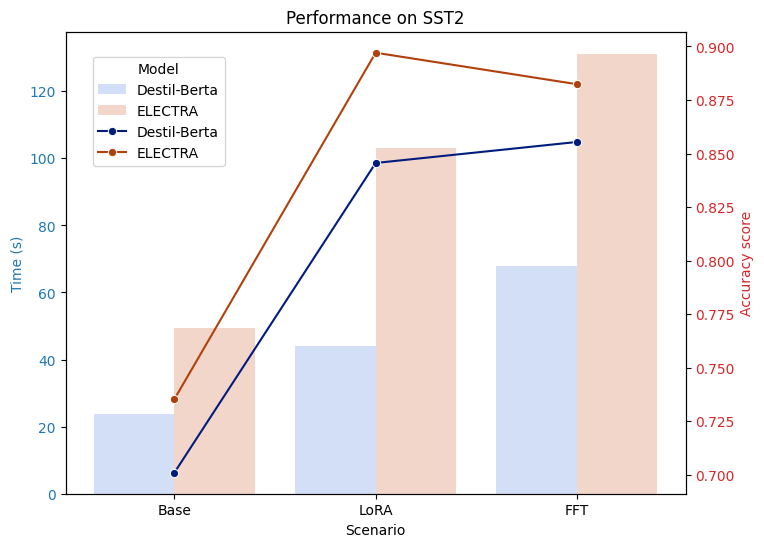

In [ ]:
vizualize_time(acc_mrpc, time_mrpc)

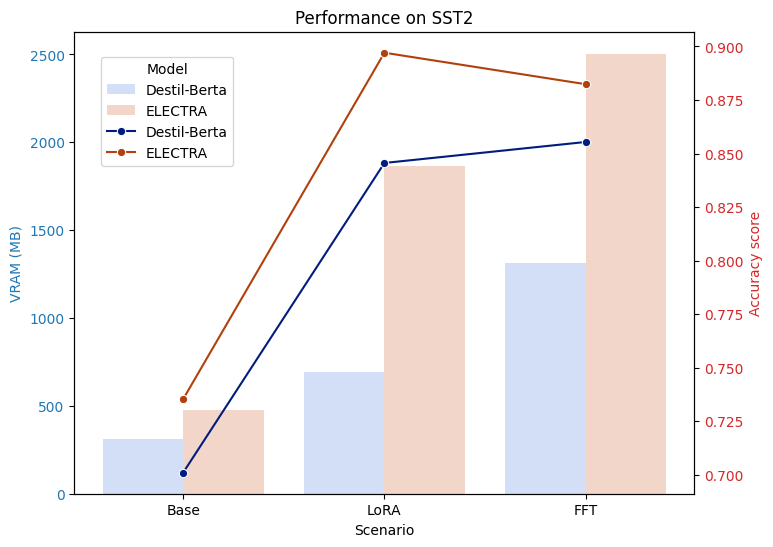

In [ ]:
vizualize_vram(acc_mrpc, vram_mrpc)